In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
%matplotlib inline

### Dados
- são carregados os dados pre-procesados no notebook: Data pre-processing

In [126]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [127]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [128]:
X_train = datos.loc[rg]
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [129]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [130]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.shape

(4205, 9)

In [131]:
datos = datos.drop(rg)
datos.shape

(4185, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [8]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [9]:
noise_input = 50
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [11]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimensão dos dados de entrada:", noise.shape)
data_sint = G.predict(noise)
print("Dimensão dos dados generados:", data_sint.shape)

Dimensão dos dados de entrada: (20, 50)
Dimensão dos dados generados: (20, 9)


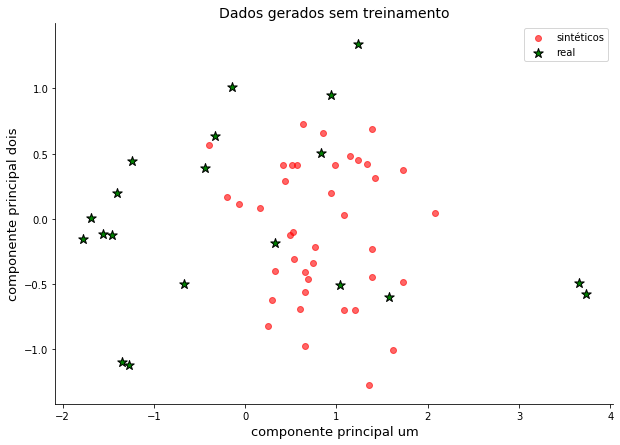

In [12]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0]*2, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.6)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [13]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [14]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [16]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [17]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    precision = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(np.mean((y_comb - y_predict)**2))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, precision

In [56]:
noise_input = 50
#Gerador
optimizerG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/1700)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/1700)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [57]:
ep = 1700
g_loss, d_loss, precision = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.695719],[Generator::loss: 0.683933], 0.990474[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.684444],[Generator::loss: 0.698044], 0.008575[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.671339],[Generator::loss: 0.682805], 0.008224[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.667434],[Generator::loss: 0.696652], 0.008338[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.670273],[Generator::loss: 0.742589], 0.008343[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.697376],[Generator::loss: 0.742050], 0.008232[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.672223],[Generator::loss: 0.650054], 0.008206[sec]
epoch:[8/1700] [Discriminator::d_loss: 0.662605],[Generator::loss: 0.627798], 0.008158[sec]
epoch:[9/1700] [Discriminator::d_loss: 0.670163],[Generator::loss: 0.684549], 0.011208[sec]
epoch:[10/1700] [Discriminator::d_loss: 0.662260],[Generator::loss: 0.692265], 0.008134[sec]
epoch:[11/1700] [Discriminator::d_loss: 0.674720],[Generator::loss: 0.676269], 

epoch:[93/1700] [Discriminator::d_loss: 0.612234],[Generator::loss: 0.779425], 0.008599[sec]
epoch:[94/1700] [Discriminator::d_loss: 0.607770],[Generator::loss: 0.750782], 0.012116[sec]
epoch:[95/1700] [Discriminator::d_loss: 0.599382],[Generator::loss: 0.733718], 0.014006[sec]
epoch:[96/1700] [Discriminator::d_loss: 0.604762],[Generator::loss: 0.722362], 0.009995[sec]
epoch:[97/1700] [Discriminator::d_loss: 0.590045],[Generator::loss: 0.690428], 0.009058[sec]
epoch:[98/1700] [Discriminator::d_loss: 0.628102],[Generator::loss: 0.777956], 0.008647[sec]
epoch:[99/1700] [Discriminator::d_loss: 0.598120],[Generator::loss: 0.655055], 0.008087[sec]
epoch:[100/1700] [Discriminator::d_loss: 0.619473],[Generator::loss: 0.762756], 0.008995[sec]
epoch:[101/1700] [Discriminator::d_loss: 0.631718],[Generator::loss: 0.701904], 0.008116[sec]
epoch:[102/1700] [Discriminator::d_loss: 0.568992],[Generator::loss: 0.714963], 0.008056[sec]
epoch:[103/1700] [Discriminator::d_loss: 0.574374],[Generator::loss

epoch:[184/1700] [Discriminator::d_loss: 0.576561],[Generator::loss: 0.809592], 0.009359[sec]
epoch:[185/1700] [Discriminator::d_loss: 0.583579],[Generator::loss: 0.794850], 0.009700[sec]
epoch:[186/1700] [Discriminator::d_loss: 0.609328],[Generator::loss: 0.843472], 0.011687[sec]
epoch:[187/1700] [Discriminator::d_loss: 0.585834],[Generator::loss: 0.887308], 0.009856[sec]
epoch:[188/1700] [Discriminator::d_loss: 0.594556],[Generator::loss: 0.832978], 0.008177[sec]
epoch:[189/1700] [Discriminator::d_loss: 0.567336],[Generator::loss: 0.811380], 0.008402[sec]
epoch:[190/1700] [Discriminator::d_loss: 0.575019],[Generator::loss: 0.810005], 0.008229[sec]
epoch:[191/1700] [Discriminator::d_loss: 0.607320],[Generator::loss: 0.776657], 0.008219[sec]
epoch:[192/1700] [Discriminator::d_loss: 0.574442],[Generator::loss: 0.786887], 0.008153[sec]
epoch:[193/1700] [Discriminator::d_loss: 0.611664],[Generator::loss: 0.832846], 0.008256[sec]
epoch:[194/1700] [Discriminator::d_loss: 0.559739],[Generato

epoch:[277/1700] [Discriminator::d_loss: 0.589994],[Generator::loss: 0.855706], 0.009464[sec]
epoch:[278/1700] [Discriminator::d_loss: 0.550353],[Generator::loss: 0.857386], 0.014524[sec]
epoch:[279/1700] [Discriminator::d_loss: 0.594523],[Generator::loss: 0.894924], 0.009029[sec]
epoch:[280/1700] [Discriminator::d_loss: 0.580793],[Generator::loss: 0.827412], 0.008580[sec]
epoch:[281/1700] [Discriminator::d_loss: 0.579557],[Generator::loss: 0.902087], 0.008564[sec]
epoch:[282/1700] [Discriminator::d_loss: 0.597529],[Generator::loss: 0.902678], 0.008174[sec]
epoch:[283/1700] [Discriminator::d_loss: 0.578969],[Generator::loss: 0.880535], 0.008304[sec]
epoch:[284/1700] [Discriminator::d_loss: 0.551161],[Generator::loss: 0.850607], 0.008275[sec]
epoch:[285/1700] [Discriminator::d_loss: 0.580624],[Generator::loss: 0.874527], 0.008397[sec]
epoch:[286/1700] [Discriminator::d_loss: 0.597644],[Generator::loss: 0.926395], 0.008207[sec]
epoch:[287/1700] [Discriminator::d_loss: 0.565030],[Generato

epoch:[369/1700] [Discriminator::d_loss: 0.572606],[Generator::loss: 0.853168], 0.011738[sec]
epoch:[370/1700] [Discriminator::d_loss: 0.544341],[Generator::loss: 0.817100], 0.011041[sec]
epoch:[371/1700] [Discriminator::d_loss: 0.580844],[Generator::loss: 0.896032], 0.008647[sec]
epoch:[372/1700] [Discriminator::d_loss: 0.598247],[Generator::loss: 0.970654], 0.008298[sec]
epoch:[373/1700] [Discriminator::d_loss: 0.551727],[Generator::loss: 0.900713], 0.008369[sec]
epoch:[374/1700] [Discriminator::d_loss: 0.543140],[Generator::loss: 0.949717], 0.008160[sec]
epoch:[375/1700] [Discriminator::d_loss: 0.554832],[Generator::loss: 0.928905], 0.008217[sec]
epoch:[376/1700] [Discriminator::d_loss: 0.549857],[Generator::loss: 0.863120], 0.008178[sec]
epoch:[377/1700] [Discriminator::d_loss: 0.570096],[Generator::loss: 0.911268], 0.008280[sec]
epoch:[378/1700] [Discriminator::d_loss: 0.570860],[Generator::loss: 0.937038], 0.008203[sec]
epoch:[379/1700] [Discriminator::d_loss: 0.557967],[Generato

epoch:[465/1700] [Discriminator::d_loss: 0.543069],[Generator::loss: 0.920777], 0.010091[sec]
epoch:[466/1700] [Discriminator::d_loss: 0.589210],[Generator::loss: 0.857777], 0.010225[sec]
epoch:[467/1700] [Discriminator::d_loss: 0.535852],[Generator::loss: 0.956697], 0.008857[sec]
epoch:[468/1700] [Discriminator::d_loss: 0.596313],[Generator::loss: 1.004839], 0.008312[sec]
epoch:[469/1700] [Discriminator::d_loss: 0.541366],[Generator::loss: 0.897816], 0.008361[sec]
epoch:[470/1700] [Discriminator::d_loss: 0.546586],[Generator::loss: 0.910103], 0.008271[sec]
epoch:[471/1700] [Discriminator::d_loss: 0.506099],[Generator::loss: 0.945278], 0.008265[sec]
epoch:[472/1700] [Discriminator::d_loss: 0.576407],[Generator::loss: 0.930674], 0.008261[sec]
epoch:[473/1700] [Discriminator::d_loss: 0.520953],[Generator::loss: 0.916461], 0.008096[sec]
epoch:[474/1700] [Discriminator::d_loss: 0.547709],[Generator::loss: 0.979232], 0.008002[sec]
epoch:[475/1700] [Discriminator::d_loss: 0.543452],[Generato

epoch:[561/1700] [Discriminator::d_loss: 0.540982],[Generator::loss: 1.104044], 0.012953[sec]
epoch:[562/1700] [Discriminator::d_loss: 0.553416],[Generator::loss: 0.979217], 0.010837[sec]
epoch:[563/1700] [Discriminator::d_loss: 0.535250],[Generator::loss: 0.865232], 0.008906[sec]
epoch:[564/1700] [Discriminator::d_loss: 0.519751],[Generator::loss: 0.900832], 0.008380[sec]
epoch:[565/1700] [Discriminator::d_loss: 0.577013],[Generator::loss: 0.959101], 0.008429[sec]
epoch:[566/1700] [Discriminator::d_loss: 0.571838],[Generator::loss: 0.918522], 0.008140[sec]
epoch:[567/1700] [Discriminator::d_loss: 0.551671],[Generator::loss: 0.876340], 0.008289[sec]
epoch:[568/1700] [Discriminator::d_loss: 0.564246],[Generator::loss: 0.889379], 0.008282[sec]
epoch:[569/1700] [Discriminator::d_loss: 0.549620],[Generator::loss: 0.912334], 0.008220[sec]
epoch:[570/1700] [Discriminator::d_loss: 0.589182],[Generator::loss: 0.934811], 0.008104[sec]
epoch:[571/1700] [Discriminator::d_loss: 0.542575],[Generato

epoch:[657/1700] [Discriminator::d_loss: 0.555056],[Generator::loss: 0.842869], 0.009579[sec]
epoch:[658/1700] [Discriminator::d_loss: 0.579714],[Generator::loss: 0.969560], 0.010685[sec]
epoch:[659/1700] [Discriminator::d_loss: 0.501405],[Generator::loss: 0.885403], 0.009160[sec]
epoch:[660/1700] [Discriminator::d_loss: 0.556894],[Generator::loss: 0.902268], 0.009855[sec]
epoch:[661/1700] [Discriminator::d_loss: 0.555766],[Generator::loss: 0.855415], 0.008623[sec]
epoch:[662/1700] [Discriminator::d_loss: 0.569078],[Generator::loss: 1.013742], 0.008281[sec]
epoch:[663/1700] [Discriminator::d_loss: 0.526277],[Generator::loss: 0.992267], 0.008146[sec]
epoch:[664/1700] [Discriminator::d_loss: 0.538377],[Generator::loss: 0.987971], 0.008147[sec]
epoch:[665/1700] [Discriminator::d_loss: 0.563008],[Generator::loss: 0.990805], 0.008396[sec]
epoch:[666/1700] [Discriminator::d_loss: 0.542665],[Generator::loss: 0.885348], 0.008136[sec]
epoch:[667/1700] [Discriminator::d_loss: 0.548061],[Generato

epoch:[753/1700] [Discriminator::d_loss: 0.529631],[Generator::loss: 0.907423], 0.009100[sec]
epoch:[754/1700] [Discriminator::d_loss: 0.559873],[Generator::loss: 0.938867], 0.010858[sec]
epoch:[755/1700] [Discriminator::d_loss: 0.578491],[Generator::loss: 0.883086], 0.009822[sec]
epoch:[756/1700] [Discriminator::d_loss: 0.513773],[Generator::loss: 0.907777], 0.008037[sec]
epoch:[757/1700] [Discriminator::d_loss: 0.581700],[Generator::loss: 0.901701], 0.008625[sec]
epoch:[758/1700] [Discriminator::d_loss: 0.520591],[Generator::loss: 0.933591], 0.008233[sec]
epoch:[759/1700] [Discriminator::d_loss: 0.550485],[Generator::loss: 0.869565], 0.008095[sec]
epoch:[760/1700] [Discriminator::d_loss: 0.565421],[Generator::loss: 0.908133], 0.008334[sec]
epoch:[761/1700] [Discriminator::d_loss: 0.524150],[Generator::loss: 0.952176], 0.008265[sec]
epoch:[762/1700] [Discriminator::d_loss: 0.524828],[Generator::loss: 1.008728], 0.008199[sec]
epoch:[763/1700] [Discriminator::d_loss: 0.549702],[Generato

epoch:[849/1700] [Discriminator::d_loss: 0.562831],[Generator::loss: 1.104643], 0.009793[sec]
epoch:[850/1700] [Discriminator::d_loss: 0.537019],[Generator::loss: 0.931332], 0.009719[sec]
epoch:[851/1700] [Discriminator::d_loss: 0.567315],[Generator::loss: 0.885973], 0.008539[sec]
epoch:[852/1700] [Discriminator::d_loss: 0.558224],[Generator::loss: 0.987214], 0.008501[sec]
epoch:[853/1700] [Discriminator::d_loss: 0.587032],[Generator::loss: 1.068076], 0.008338[sec]
epoch:[854/1700] [Discriminator::d_loss: 0.561007],[Generator::loss: 0.881170], 0.008217[sec]
epoch:[855/1700] [Discriminator::d_loss: 0.563115],[Generator::loss: 0.939499], 0.008143[sec]
epoch:[856/1700] [Discriminator::d_loss: 0.584310],[Generator::loss: 1.031335], 0.008262[sec]
epoch:[857/1700] [Discriminator::d_loss: 0.553422],[Generator::loss: 0.972774], 0.008268[sec]
epoch:[858/1700] [Discriminator::d_loss: 0.519455],[Generator::loss: 0.880238], 0.008372[sec]
epoch:[859/1700] [Discriminator::d_loss: 0.597266],[Generato

epoch:[941/1700] [Discriminator::d_loss: 0.550740],[Generator::loss: 0.934684], 0.008758[sec]
epoch:[942/1700] [Discriminator::d_loss: 0.635266],[Generator::loss: 0.782520], 0.014800[sec]
epoch:[943/1700] [Discriminator::d_loss: 0.587923],[Generator::loss: 0.857385], 0.009546[sec]
epoch:[944/1700] [Discriminator::d_loss: 0.581572],[Generator::loss: 0.880269], 0.008749[sec]
epoch:[945/1700] [Discriminator::d_loss: 0.600563],[Generator::loss: 0.866427], 0.008172[sec]
epoch:[946/1700] [Discriminator::d_loss: 0.597653],[Generator::loss: 0.880832], 0.008498[sec]
epoch:[947/1700] [Discriminator::d_loss: 0.603159],[Generator::loss: 0.988889], 0.008214[sec]
epoch:[948/1700] [Discriminator::d_loss: 0.559576],[Generator::loss: 0.946275], 0.008233[sec]
epoch:[949/1700] [Discriminator::d_loss: 0.628606],[Generator::loss: 0.871294], 0.008099[sec]
epoch:[950/1700] [Discriminator::d_loss: 0.618710],[Generator::loss: 0.785362], 0.008255[sec]
epoch:[951/1700] [Discriminator::d_loss: 0.571204],[Generato

epoch:[1036/1700] [Discriminator::d_loss: 0.708990],[Generator::loss: 0.780392], 0.009987[sec]
epoch:[1037/1700] [Discriminator::d_loss: 0.722259],[Generator::loss: 0.933109], 0.010422[sec]
epoch:[1038/1700] [Discriminator::d_loss: 0.687353],[Generator::loss: 0.901713], 0.008947[sec]
epoch:[1039/1700] [Discriminator::d_loss: 0.604687],[Generator::loss: 0.864688], 0.008394[sec]
epoch:[1040/1700] [Discriminator::d_loss: 0.705798],[Generator::loss: 0.933627], 0.008287[sec]
epoch:[1041/1700] [Discriminator::d_loss: 0.728001],[Generator::loss: 0.841389], 0.008207[sec]
epoch:[1042/1700] [Discriminator::d_loss: 0.662456],[Generator::loss: 0.957356], 0.008216[sec]
epoch:[1043/1700] [Discriminator::d_loss: 0.666064],[Generator::loss: 0.819496], 0.008334[sec]
epoch:[1044/1700] [Discriminator::d_loss: 0.631326],[Generator::loss: 0.900347], 0.008145[sec]
epoch:[1045/1700] [Discriminator::d_loss: 0.620801],[Generator::loss: 0.903649], 0.008249[sec]
epoch:[1046/1700] [Discriminator::d_loss: 0.663667

epoch:[1132/1700] [Discriminator::d_loss: 0.683771],[Generator::loss: 0.855501], 0.009812[sec]
epoch:[1133/1700] [Discriminator::d_loss: 0.647106],[Generator::loss: 0.774521], 0.010292[sec]
epoch:[1134/1700] [Discriminator::d_loss: 0.632381],[Generator::loss: 0.882964], 0.009176[sec]
epoch:[1135/1700] [Discriminator::d_loss: 0.670011],[Generator::loss: 0.926005], 0.008066[sec]
epoch:[1136/1700] [Discriminator::d_loss: 0.666875],[Generator::loss: 1.002936], 0.008278[sec]
epoch:[1137/1700] [Discriminator::d_loss: 0.681223],[Generator::loss: 0.777784], 0.008240[sec]
epoch:[1138/1700] [Discriminator::d_loss: 0.665879],[Generator::loss: 0.770242], 0.008492[sec]
epoch:[1139/1700] [Discriminator::d_loss: 0.729927],[Generator::loss: 0.838386], 0.008278[sec]
epoch:[1140/1700] [Discriminator::d_loss: 0.684268],[Generator::loss: 0.712293], 0.008102[sec]
epoch:[1141/1700] [Discriminator::d_loss: 0.671488],[Generator::loss: 0.883145], 0.008380[sec]
epoch:[1142/1700] [Discriminator::d_loss: 0.696752

epoch:[1226/1700] [Discriminator::d_loss: 0.722701],[Generator::loss: 0.851627], 0.008790[sec]
epoch:[1227/1700] [Discriminator::d_loss: 0.682223],[Generator::loss: 0.865151], 0.009556[sec]
epoch:[1228/1700] [Discriminator::d_loss: 0.717378],[Generator::loss: 0.846167], 0.009395[sec]
epoch:[1229/1700] [Discriminator::d_loss: 0.744129],[Generator::loss: 0.827629], 0.008441[sec]
epoch:[1230/1700] [Discriminator::d_loss: 0.670848],[Generator::loss: 0.841322], 0.008277[sec]
epoch:[1231/1700] [Discriminator::d_loss: 0.668867],[Generator::loss: 0.741722], 0.008451[sec]
epoch:[1232/1700] [Discriminator::d_loss: 0.698683],[Generator::loss: 0.859555], 0.008425[sec]
epoch:[1233/1700] [Discriminator::d_loss: 0.670736],[Generator::loss: 0.836479], 0.008184[sec]
epoch:[1234/1700] [Discriminator::d_loss: 0.620061],[Generator::loss: 0.847535], 0.008140[sec]
epoch:[1235/1700] [Discriminator::d_loss: 0.644555],[Generator::loss: 0.822857], 0.008613[sec]
epoch:[1236/1700] [Discriminator::d_loss: 0.729438

epoch:[1321/1700] [Discriminator::d_loss: 0.667029],[Generator::loss: 0.719114], 0.009071[sec]
epoch:[1322/1700] [Discriminator::d_loss: 0.738978],[Generator::loss: 0.801566], 0.010645[sec]
epoch:[1323/1700] [Discriminator::d_loss: 0.680125],[Generator::loss: 0.706749], 0.008505[sec]
epoch:[1324/1700] [Discriminator::d_loss: 0.720504],[Generator::loss: 0.701991], 0.008803[sec]
epoch:[1325/1700] [Discriminator::d_loss: 0.719368],[Generator::loss: 0.806305], 0.008502[sec]
epoch:[1326/1700] [Discriminator::d_loss: 0.665608],[Generator::loss: 0.776313], 0.008322[sec]
epoch:[1327/1700] [Discriminator::d_loss: 0.722390],[Generator::loss: 0.779958], 0.008403[sec]
epoch:[1328/1700] [Discriminator::d_loss: 0.710929],[Generator::loss: 0.751730], 0.008305[sec]
epoch:[1329/1700] [Discriminator::d_loss: 0.756300],[Generator::loss: 0.753603], 0.008480[sec]
epoch:[1330/1700] [Discriminator::d_loss: 0.641653],[Generator::loss: 0.890864], 0.008280[sec]
epoch:[1331/1700] [Discriminator::d_loss: 0.719087

epoch:[1417/1700] [Discriminator::d_loss: 0.729164],[Generator::loss: 0.721600], 0.009508[sec]
epoch:[1418/1700] [Discriminator::d_loss: 0.700233],[Generator::loss: 0.703744], 0.010335[sec]
epoch:[1419/1700] [Discriminator::d_loss: 0.742957],[Generator::loss: 0.798509], 0.008849[sec]
epoch:[1420/1700] [Discriminator::d_loss: 0.714500],[Generator::loss: 0.727970], 0.008458[sec]
epoch:[1421/1700] [Discriminator::d_loss: 0.717461],[Generator::loss: 0.700775], 0.008407[sec]
epoch:[1422/1700] [Discriminator::d_loss: 0.703061],[Generator::loss: 0.749201], 0.008102[sec]
epoch:[1423/1700] [Discriminator::d_loss: 0.691980],[Generator::loss: 0.776251], 0.008490[sec]
epoch:[1424/1700] [Discriminator::d_loss: 0.698843],[Generator::loss: 0.797441], 0.008341[sec]
epoch:[1425/1700] [Discriminator::d_loss: 0.685261],[Generator::loss: 0.860473], 0.008341[sec]
epoch:[1426/1700] [Discriminator::d_loss: 0.715669],[Generator::loss: 0.731179], 0.008223[sec]
epoch:[1427/1700] [Discriminator::d_loss: 0.702867

epoch:[1513/1700] [Discriminator::d_loss: 0.704318],[Generator::loss: 0.828131], 0.010215[sec]
epoch:[1514/1700] [Discriminator::d_loss: 0.675099],[Generator::loss: 0.776027], 0.011596[sec]
epoch:[1515/1700] [Discriminator::d_loss: 0.686548],[Generator::loss: 0.736891], 0.009257[sec]
epoch:[1516/1700] [Discriminator::d_loss: 0.748247],[Generator::loss: 0.764078], 0.008590[sec]
epoch:[1517/1700] [Discriminator::d_loss: 0.717532],[Generator::loss: 0.814797], 0.008323[sec]
epoch:[1518/1700] [Discriminator::d_loss: 0.718560],[Generator::loss: 0.705643], 0.008267[sec]
epoch:[1519/1700] [Discriminator::d_loss: 0.679882],[Generator::loss: 0.733990], 0.008262[sec]
epoch:[1520/1700] [Discriminator::d_loss: 0.644961],[Generator::loss: 0.724275], 0.008346[sec]
epoch:[1521/1700] [Discriminator::d_loss: 0.686187],[Generator::loss: 0.792144], 0.008485[sec]
epoch:[1522/1700] [Discriminator::d_loss: 0.656139],[Generator::loss: 0.760562], 0.008203[sec]
epoch:[1523/1700] [Discriminator::d_loss: 0.674652

epoch:[1608/1700] [Discriminator::d_loss: 0.679922],[Generator::loss: 0.803782], 0.008703[sec]
epoch:[1609/1700] [Discriminator::d_loss: 0.725782],[Generator::loss: 0.763945], 0.009722[sec]
epoch:[1610/1700] [Discriminator::d_loss: 0.671646],[Generator::loss: 0.816503], 0.009964[sec]
epoch:[1611/1700] [Discriminator::d_loss: 0.691169],[Generator::loss: 0.751274], 0.008629[sec]
epoch:[1612/1700] [Discriminator::d_loss: 0.689528],[Generator::loss: 0.787041], 0.008152[sec]
epoch:[1613/1700] [Discriminator::d_loss: 0.688770],[Generator::loss: 0.786891], 0.008380[sec]
epoch:[1614/1700] [Discriminator::d_loss: 0.691934],[Generator::loss: 0.791014], 0.008414[sec]
epoch:[1615/1700] [Discriminator::d_loss: 0.657600],[Generator::loss: 0.880817], 0.008319[sec]
epoch:[1616/1700] [Discriminator::d_loss: 0.666448],[Generator::loss: 0.741577], 0.008049[sec]
epoch:[1617/1700] [Discriminator::d_loss: 0.716609],[Generator::loss: 0.795903], 0.008300[sec]
epoch:[1618/1700] [Discriminator::d_loss: 0.688814

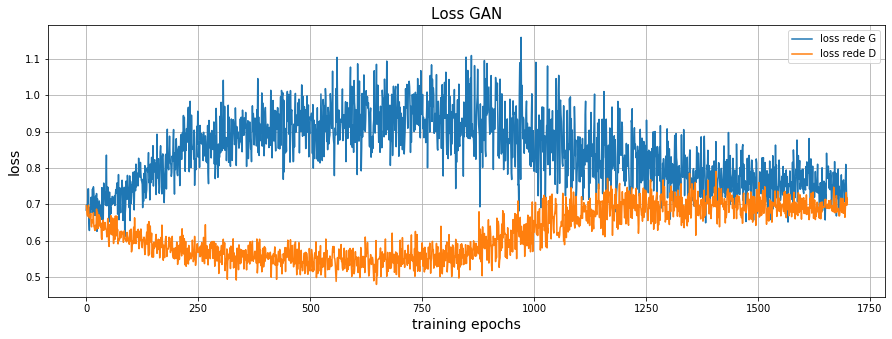

In [58]:
plt.figure(figsize=(15,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

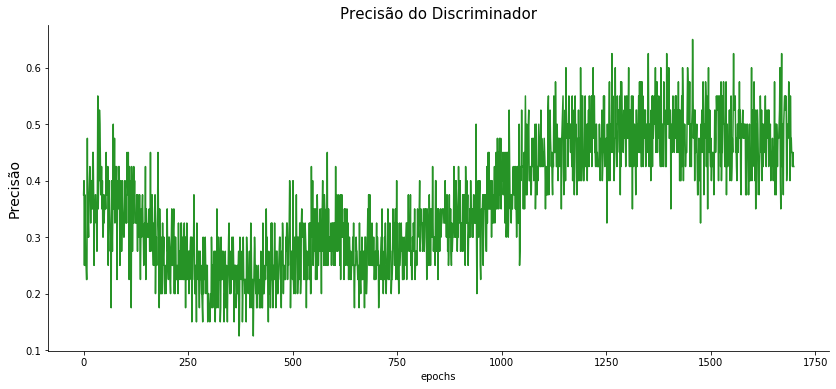

In [59]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85);

(20, 2) (300, 2)


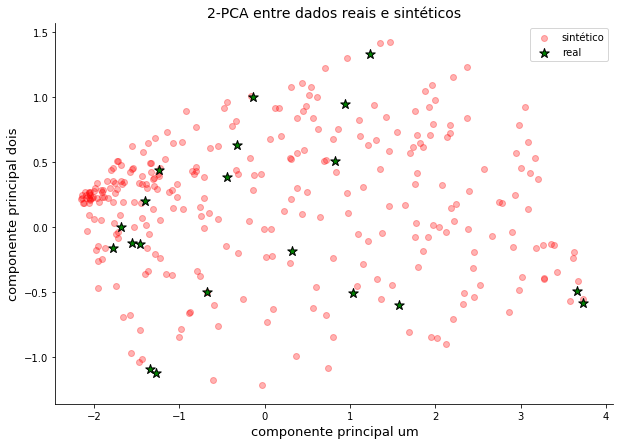

In [60]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [61]:
score = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(np.mean((y_test - y_predict)**2))

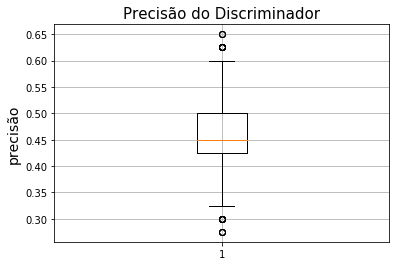

In [62]:
plt.title("Precisão do Discriminador", fontsize=15)
plt.ylabel("precisão", fontsize=14)
plt.grid("y")
plt.boxplot(score);

In [63]:
np.mean(score), np.std(score), np.median(score)

(0.46083999999999997, 0.05589717703068734, 0.45)

In [64]:
X_train.shape

(20, 9)

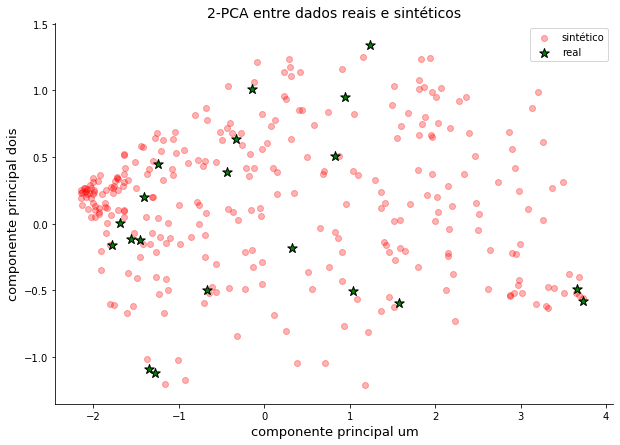

In [144]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train.iloc[:10], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [201]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.138, gamma=.1).fit(X_train)

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train.iloc[:10]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train.iloc[10:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.7483870967741936
score nos genes de referência de treinamento:  0.5
score nos genes de referência no utilizados pro treinamento:  0.9
score em todos os genes de referência:  0.7


In [147]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060889,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.078005,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425601,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211


In [148]:
predict_cand = clf.predict(datos)

In [149]:
cand = datos[predict_cand == 1]
no_cand = datos[predict_cand == -1]
cand.shape, no_cand.shape

((615, 9), (3570, 9))

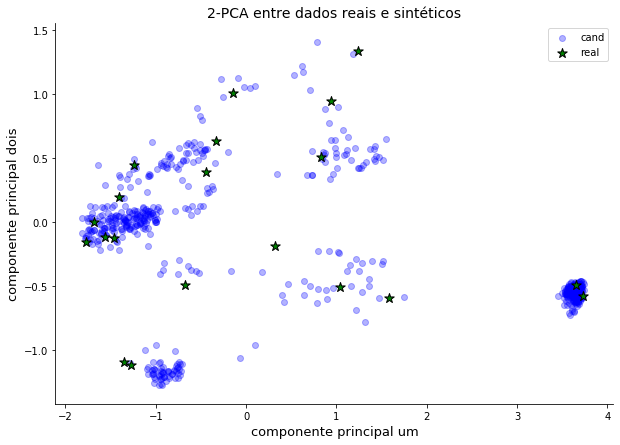

In [150]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1, edgecolors="black")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [151]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [152]:
datos.loc[cand.loc[rg_moose].dropna().index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242
thrW,-0.198341,-0.156393,-0.103735,-0.003529,-0.075905,-0.175493,-0.166364,1.018885,-0.263904
zupT,-0.722573,0.721750,0.753271,0.759741,0.757655,0.733104,0.654379,0.607526,0.687909


In [153]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242
thrW,-0.198341,-0.156393,-0.103735,-0.003529,-0.075905,-0.175493,-0.166364,1.018885,-0.263904
zupT,-0.722573,0.721750,0.753271,0.759741,0.757655,0.733104,0.654379,0.607526,0.687909


In [140]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [141]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
